In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import importlib
import random
import yaml
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

import sys
sys.path.append("../../")  
import utils
importlib.reload(utils)

from utils import *

In [7]:
def plot_selected_loss_curves(dataset_dict, k_values, dataset_name, seqlen, random_seed=42, selected_num=5, y_logscale=True, drop_threshold=1e-4, drop_until_step=50000):
    random.seed(random_seed)

    # get the specific dataframe for this sequence length
    if seqlen not in dataset_dict:
        raise ValueError(f"Sequence length {seqlen} not found in dataset_dict keys: {list(dataset_dict.keys())}")
    
    df = dataset_dict[seqlen]

    fig, ax = plt.subplots(figsize=(9, 6))

    # separate members and non-members
    members = df[df['label'] == 1]
    non_members = df[df['label'] == 0]


    # define early-dropping condition
    k_cutoff = [k for k in k_values if k <= drop_until_step]
    def drops_early(row):
        return any(row[f"loss_{k}"] < drop_threshold for k in k_cutoff)

    early_droppers = members[members.apply(drops_early, axis=1)]
    other_members = members.drop(early_droppers.index)

    # sample members: prioritise early-droppers
    n_select = min(selected_num, len(members))
    if len(early_droppers) >= n_select:
        members_sample = early_droppers.sample(n=n_select, random_state=random_seed)
    else:
        needed = n_select - len(early_droppers)
        fill = other_members.sample(n=min(needed, len(other_members)), random_state=random_seed)
        members_sample = pd.concat([early_droppers, fill])

    

    # sample non-members normally
    non_members_sample = non_members.sample(n=min(selected_num, len(non_members)), random_state=random_seed)

    # plot members
    for _, row in members_sample.iterrows():
        y = [row[f"loss_{k}"] for k in k_values]
        ax.plot([k/1000 for k in k_values], y, color='blue', alpha=0.6)

    # plot non-members
    for _, row in non_members_sample.iterrows():
        y = [row[f"loss_{k}"] for k in k_values]
        ax.plot([k/1000 for k in k_values], y, color='orange', alpha=0.6)

    ax.plot([], [], color='blue', label='Member')
    ax.plot([], [], color='orange', label='Non-member')

    # ax.set_title(f"{dataset_name} | SeqLen={seqlen}", fontsize=22)
    ax.set_ylabel('Normalised Losses', fontsize=20)
    ax.set_xlabel('Training steps (k)', fontsize=20)

    if y_logscale:
        ax.set_yscale('log')
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.legend(fontsize=16)

    plt.tight_layout()
    plt.show()

In [9]:
def plot_sample_loss_curves_by_ppl(dataset_dict, k_values, dataset_name):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 16), sharex=True)
    axes = axes.flatten()

    plot_idx = 0 

    for i, (title, df) in enumerate(dataset_dict.items()):
        if df.empty:
            continue 

        ax = axes[plot_idx]
        for idx, row in df.iterrows():
            # y = row['loss_traces'][1:]
            y = [row[f"loss_{k}"] for k in k_values]
            color = 'green' if row['label'] == 1 else 'red'
            ax.plot(k_values, y, color=color, alpha=0.5)
            
            end_x = k_values[-1]
            end_y = y[-1]
            label = f"{row['llama_ppl']:.2f}"  # format to 2 decimal places
            ax.text(end_x + 100, end_y, label, color=color, fontsize=8)

        ax.set_title(f"Ppl bucket: {title}")
        ax.set_xlabel('Training steps')
        ax.set_ylabel('Loss')
        ax.grid(True)
        ax.legend()

        plot_idx += 1
        
    for i in range(plot_idx, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f"Selected per sample losses: {dataset_name}")
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    plt.show()

## Wikipedia Pythia 6.9B (Pile-RS-Truncated)

In [3]:
seq_lens = [64, 128, 256, 512, 1024, 2048]
dataset_wiki_pythia69b = {}

for seqlen in seq_lens:
    with open(f"../../../data//pile/pile_rs_truncated/wiki/pythia6-9b_processed/pile_reservoirv2_wiki_seqlen{seqlen}_pythia-6.9b_processed.pkl", "rb") as f:
        dataset_wiki_pythia69b[seqlen] = pd.read_pickle(f)


In [4]:
dataset_wiki_pythia69b_normalised = normalize_loss_dfs(dataset_wiki_pythia69b, loss_columns)

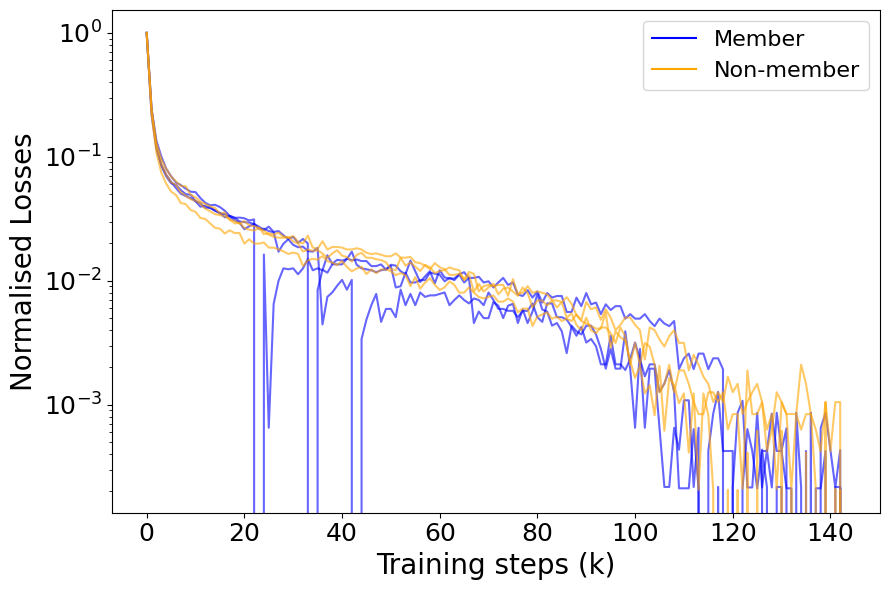

In [8]:
plot_selected_loss_curves(dataset_wiki_pythia69b_normalised, k_values, "Wiki Normalised Losses (Pythia 6.9B)", 2048, 12, 3, True)

### Exploring New Metrics

1. Ratio of CLFA:S2Conv
2. Truncated CLFA (CLFA[:k])
3. Slope of cumulative CLFA[:k]
4. Stability Ratio

In [10]:
def plot_auc_tpr_method(results: dict, title, colors=CB_color_cycle):
    x_vals = sorted(results.keys())

    # Extract all sequence lengths from one entry
    seq_lens = sorted(results[next(iter(results))]['AUC'].keys())

    # ---- Plot AUC ----
    plt.figure(figsize=(8, 5))
    for i , seq in enumerate(seq_lens):
        y_vals = [results[x]['AUC'][seq] for x in x_vals]
        plt.plot(x_vals, y_vals, marker='o', label=f"seq_len={seq}", color = colors[i % len(colors)])

    plt.xlabel("k")
    plt.ylabel("AUC")
    plt.title(f"AUC of {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---- Plot TPR ----
    plt.figure(figsize=(8, 5))
    for i, seq in enumerate(seq_lens):
        y_vals = [results[x]['TPR'][seq] for x in x_vals]
        plt.plot(x_vals, y_vals, marker='o', label=f"seq_len={seq}", color = colors[i % len(colors)])

    plt.xlabel("k")
    plt.ylabel("TPR")
    plt.title(f"TPR @ 1% FPR of {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
def plot_metric_roc(dataset_dict, k, compute_metric, flipped=True, loss_columns=loss_columns, target_fpr=0.01):
    fig = plt.figure(figsize=(8,6))
    colors = plt.cm.tab10.colors

    seq_len_aucs = {}
    seq_len_tpr_at_target = {}

    for idx, (title, df) in enumerate(dataset_dict.items()):

        stability_index = df.apply(lambda row: compute_metric(row, loss_columns, k), axis=1)

        y_true = df['label']
        y_score = stability_index
        color = colors[idx % len(colors)] 

        if flipped:
            y_score = -y_score
        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        tpr_at_target = np.interp(target_fpr, fpr, tpr)
        seq_len_aucs[title] = roc_auc
        seq_len_tpr_at_target[title] = tpr_at_target

        plt.plot(fpr, tpr, color=color, label=f'{title} (AUC = {roc_auc:.3f})')
        plt.axhline(y=tpr_at_target, color=color, linestyle='--', label = f'TPR @ {target_fpr * 100}% FPR ({title}) = {tpr_at_target:.4f}')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xscale('log')
    plt.yscale('log')
    # plt.title(f'ROC Curve for Stability Index of Wi')
    plt.grid(True)
    plt.legend(loc='lower right', fontsize='small')
    plt.tight_layout()
    plt.show()

    return seq_len_aucs, seq_len_tpr_at_target



#### 1. Ratio of CLFA:S2Conv

In [29]:
def compute_ratio_metric(row, loss_columns, epsilon=0.05, final_fraction=0.1):
    losses = np.array(row[loss_columns], dtype=float)
    n_steps = len(losses)
    steps = np.arange(n_steps)

    # Estimate final loss
    cutoff = int(n_steps * (1 - final_fraction))
    L_final = losses[cutoff:].mean()

    # Convergence threshold
    threshold = (1 + epsilon) * L_final

    # First index where loss <= threshold
    idx = np.where(losses <= threshold)[0]
    if len(idx) == 0:
        s2conv=steps[-1]
    else:
        s2conv=int(steps[idx[0]])

    fluct_sum = np.sum(np.abs(np.diff(losses)))

    return fluct_sum / s2conv

#### 2. Truncated CLFA (CLFA[:k])

In [19]:
def compute_clfa_k(row, loss_columns, k=None):
    if k is None:
        k = len(loss_columns)
    selected_losses = np.array(row[loss_columns[:k]], dtype=float)
    diffs = np.abs(np.diff(selected_losses))
    return np.sum(diffs)

k: 20


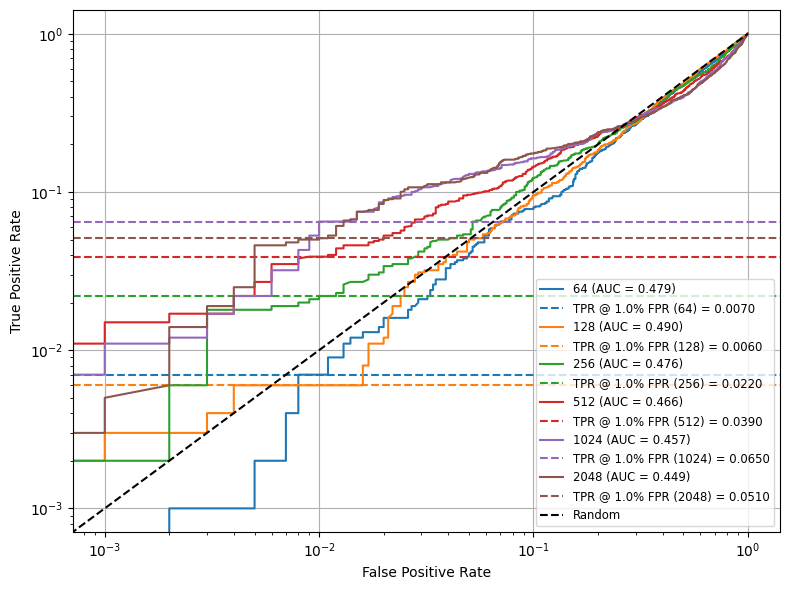

k: 40


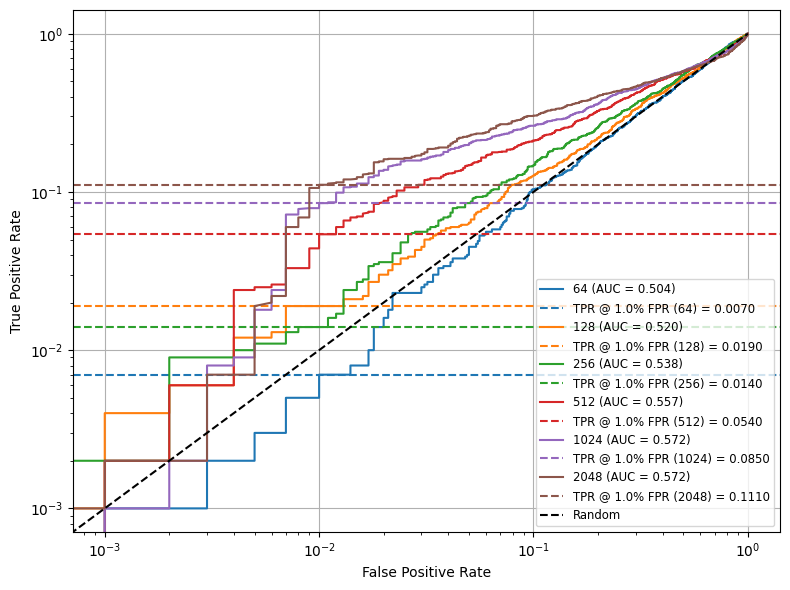

k: 60


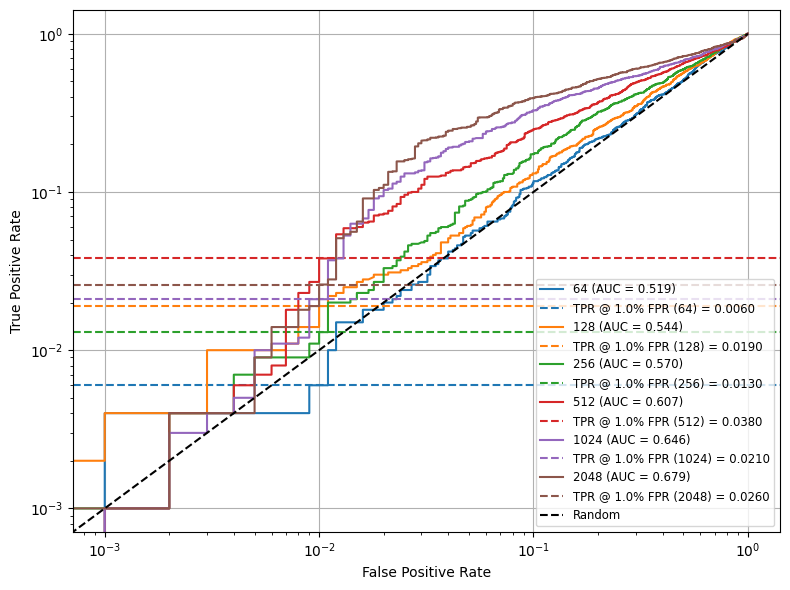

k: 80


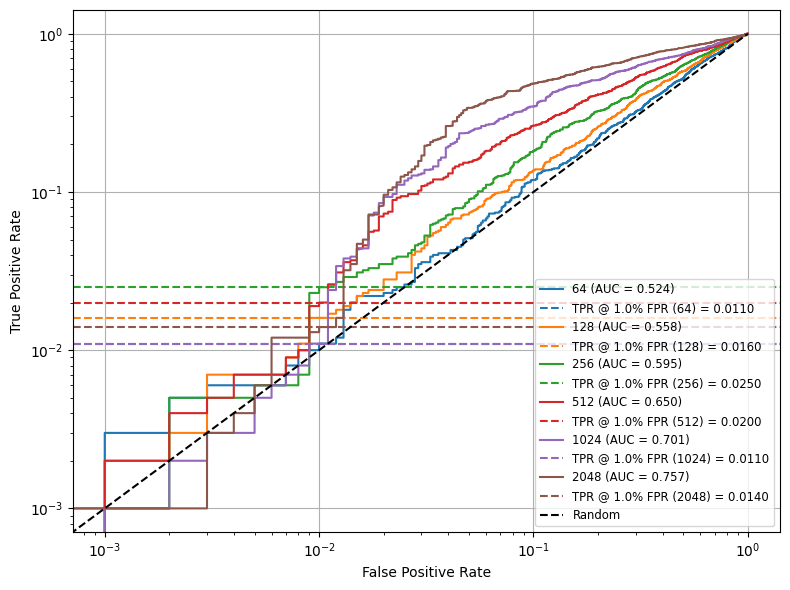

k: 100


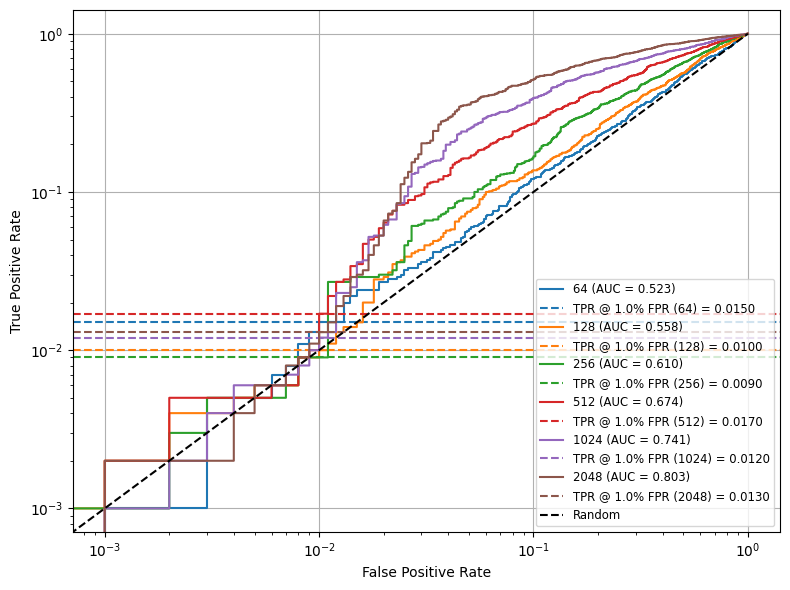

k: 120


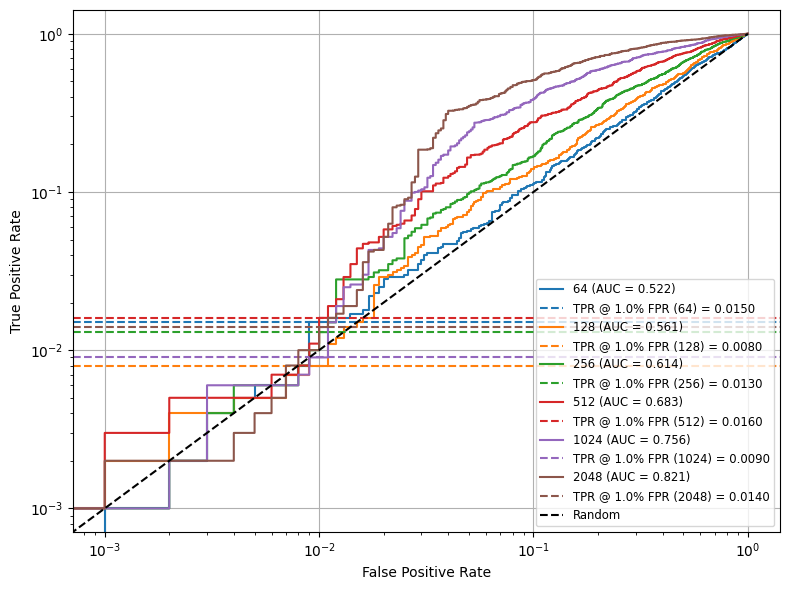

k: 144


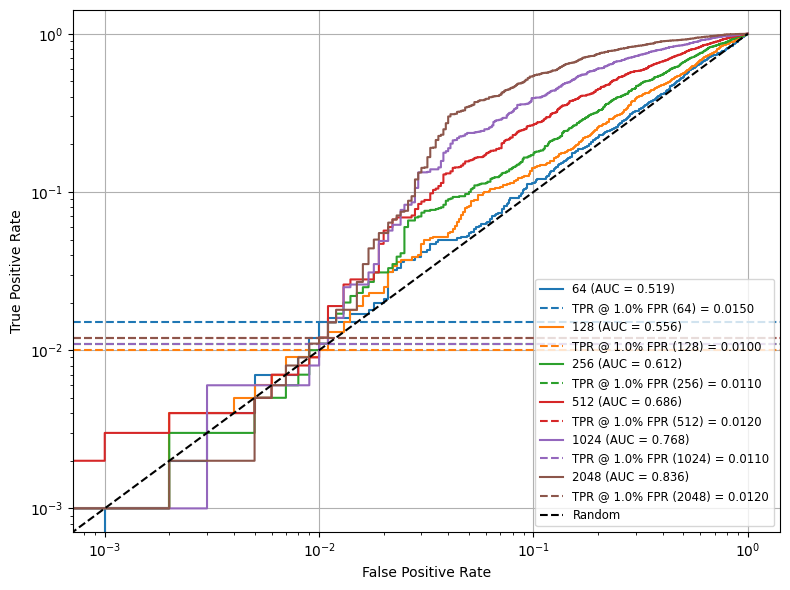

In [22]:
results_clfa_k = {}

for k in [20, 40, 60, 80, 100, 120, 144]:
    print(f'k: {k}')
    results_clfa_k[k] = {}
    results_clfa_k[k]["AUC"], results_clfa_k[k]["TPR"] = plot_metric_roc(dataset_wiki_pythia69b_normalised, k, compute_clfa_k, False)

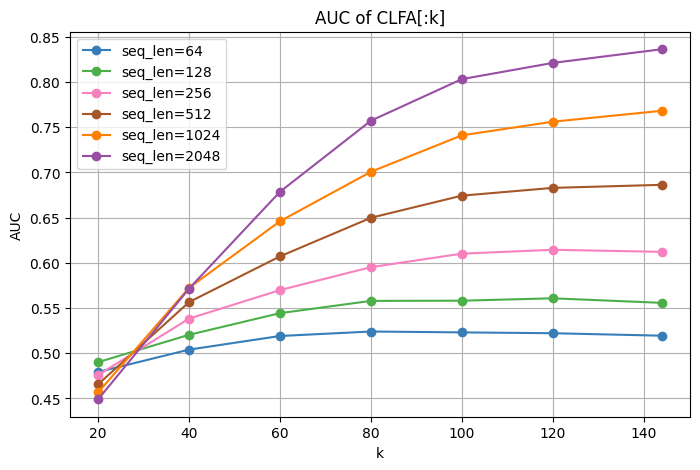

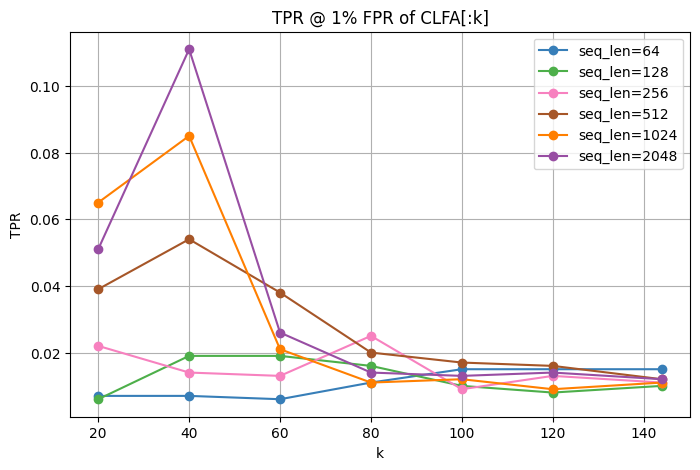

In [23]:
plot_auc_tpr_method(results_clfa_k, title='CLFA[:k]')

#### 3. Slope of cumulative CLFA[:k]

In [16]:
def compute_cumulative_clfa_row(row, loss_columns, k):
    losses = np.array(row[loss_columns[:k]], dtype=float)
    diffs = np.abs(np.diff(losses))  # absolute differences
    cumulative = np.cumsum(diffs)    # running sum
    return [0.0] + cumulative.tolist()

In [17]:
def compute_cumulative_clfa_k_metric(row, loss_columns, k):
    clfa_curve = compute_cumulative_clfa_row(row, loss_columns, k)
    return compute_loss_trace_slope(clfa_curve)

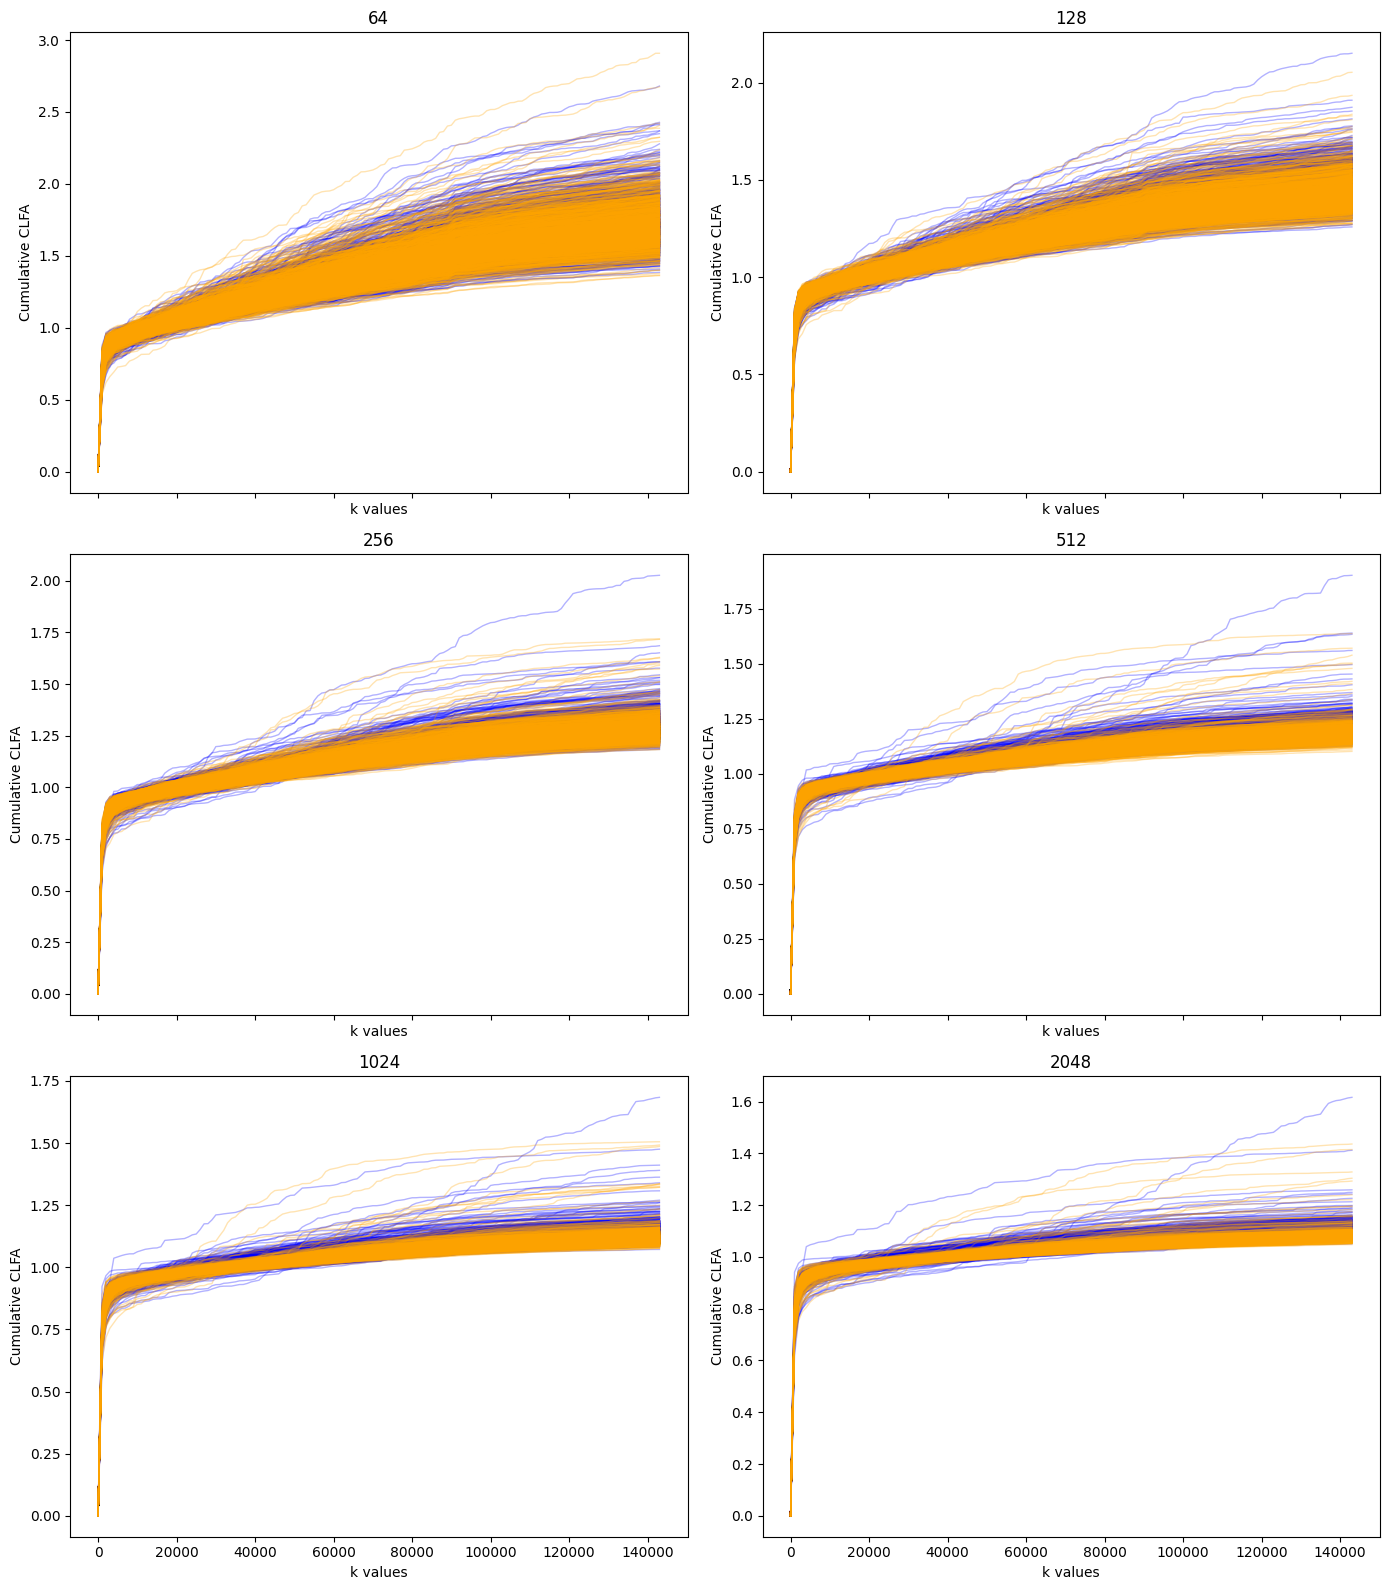

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(14, 16), sharex=True, sharey=False)  
axes = axes.flatten()
colors = {0: "orange", 1: "blue"}

for idx, (title, df) in enumerate(dataset_wiki_pythia69b_normalised.items()):
    ax = axes[idx]
    clfa_cumulative = df.apply(lambda row: compute_cumulative_clfa_row(row, loss_columns, 144), axis=1)
    clfa_df = pd.DataFrame(clfa_cumulative.tolist(), index=df.index)

    x = k_values
    for i, row_vals in clfa_df.iterrows():
        label_val = df.loc[i, "label"]
        ax.plot(x, row_vals.values,
                color=colors[label_val],
                alpha=0.3, linewidth=1)

    ax.set_title(title)
    ax.set_xlabel("k values")
    ax.set_ylabel("Cumulative CLFA")
plt.tight_layout()
plt.show()

k: 20


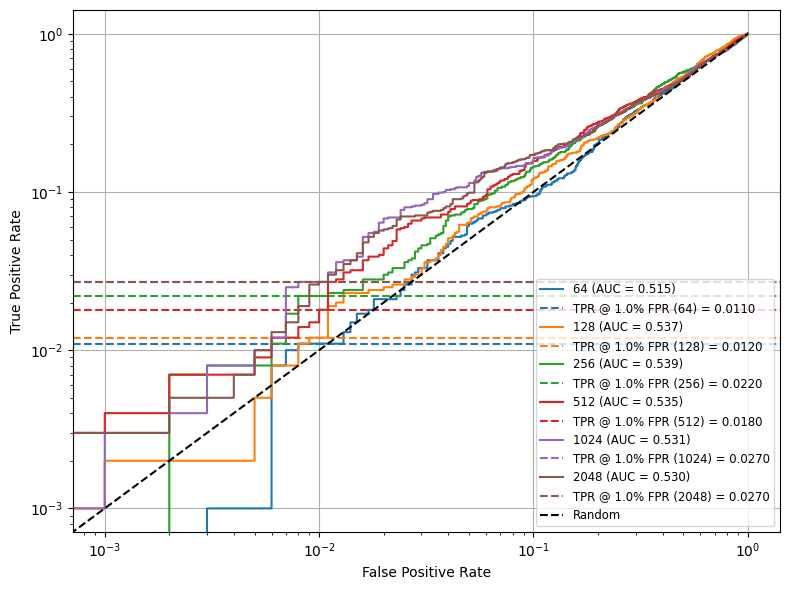

k: 40


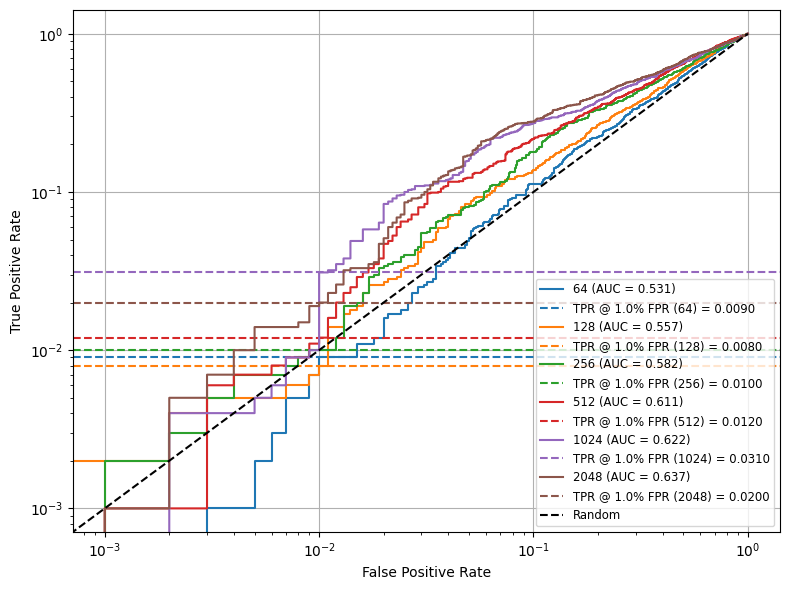

k: 60


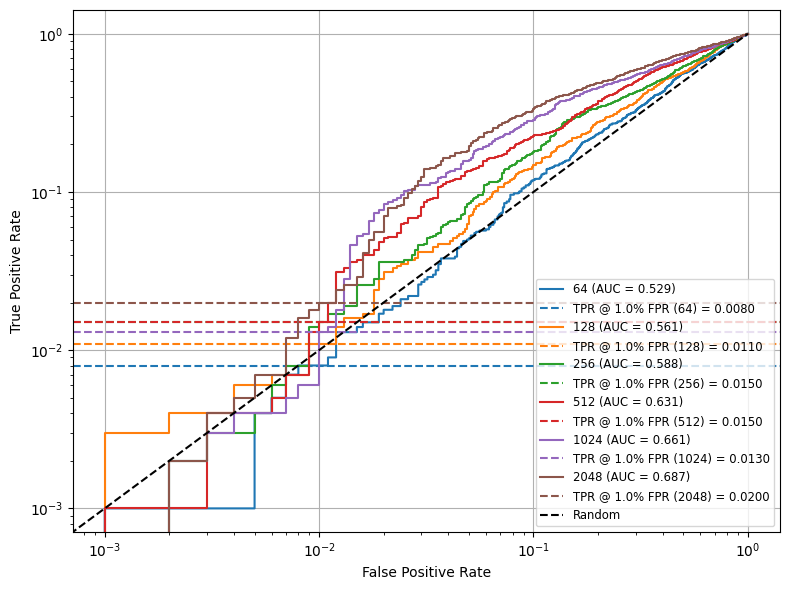

k: 80


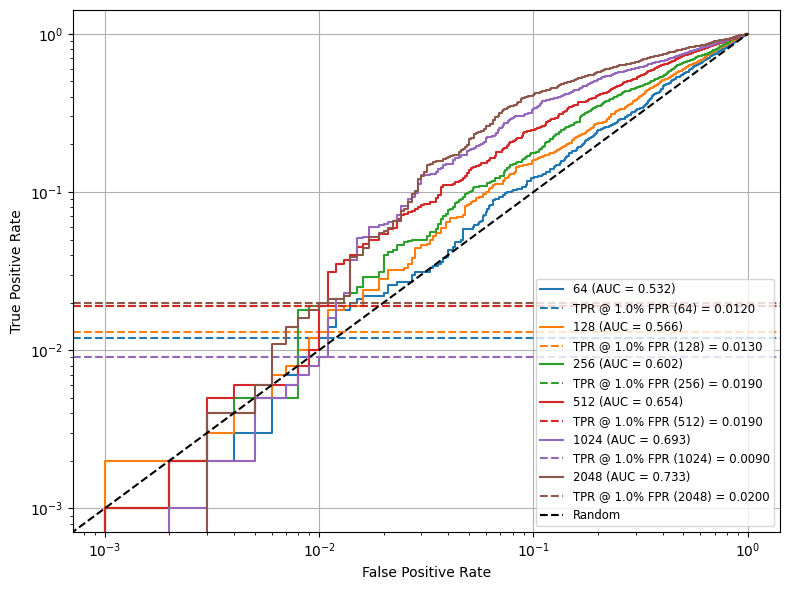

k: 100


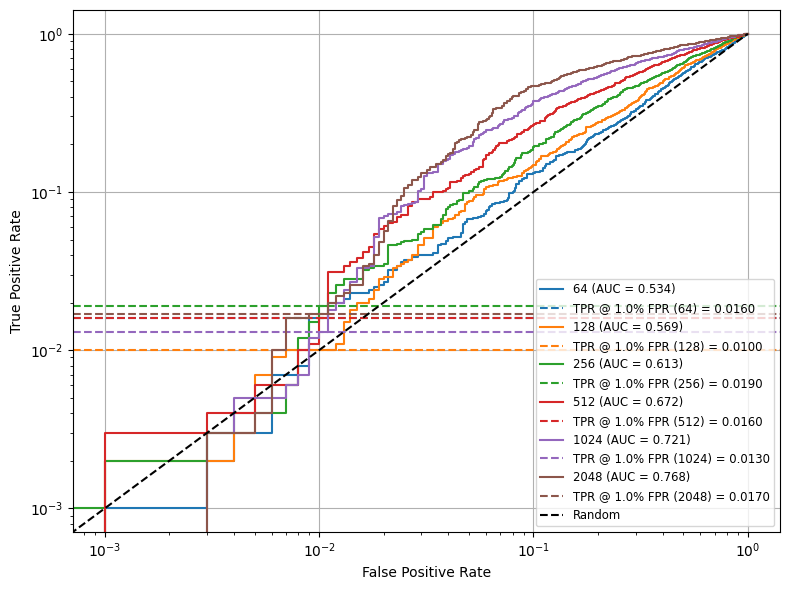

k: 120


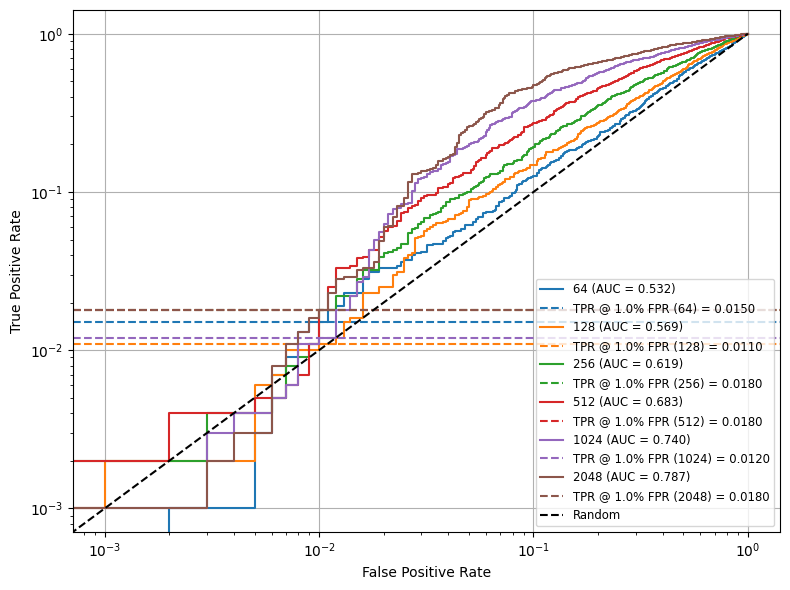

k: 144


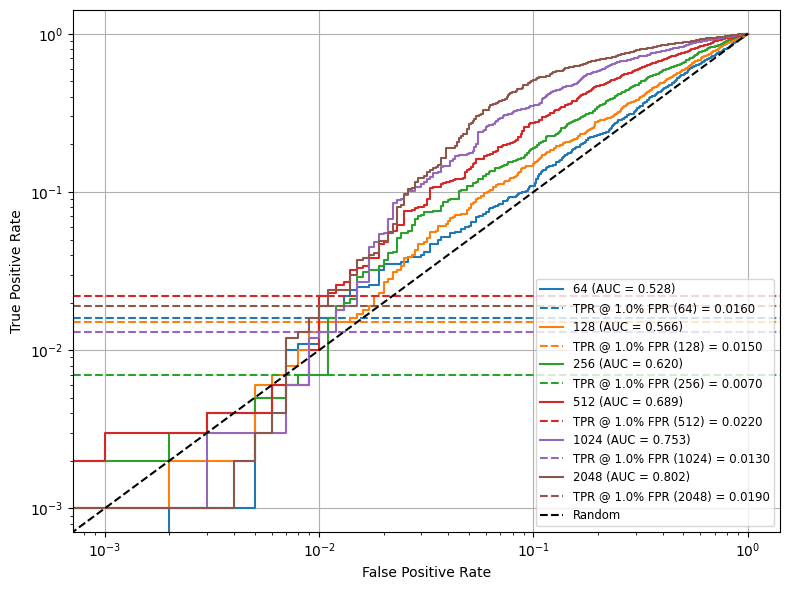

In [26]:
results_slope_cum_clfa_from_k = {}

for k in [20,40,60,80,100,120, 144]:
    print(f'k: {k}')
    results_slope_cum_clfa_from_k[k] = {}
    results_slope_cum_clfa_from_k[k]["AUC"], results_slope_cum_clfa_from_k[k]["TPR"] = plot_metric_roc(dataset_wiki_pythia69b_normalised, k, compute_cumulative_clfa_k_metric, False)

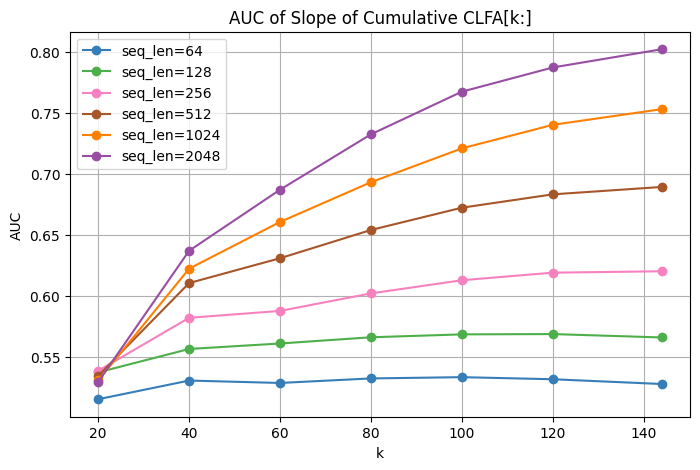

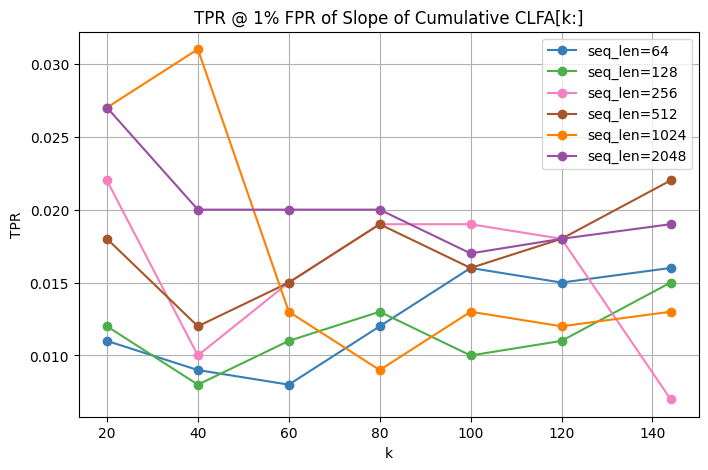

In [27]:
plot_auc_tpr_method(results_slope_cum_clfa_from_k, title='Slope of Cumulative CLFA[k:]')

#### 4. Stability Ratio

In [13]:
def compute_stability_ratio_metric(row, loss_columns, k):
    losses = np.array(row[loss_columns[0:k]], dtype=float)
    diffs = np.abs(np.diff(losses))

    last_losses = np.array(row[loss_columns[-k:]], dtype=float)
    last_diffs = np.abs(np.diff(last_losses))

    return np.sum(diffs) / np.sum(last_diffs)

k: 10


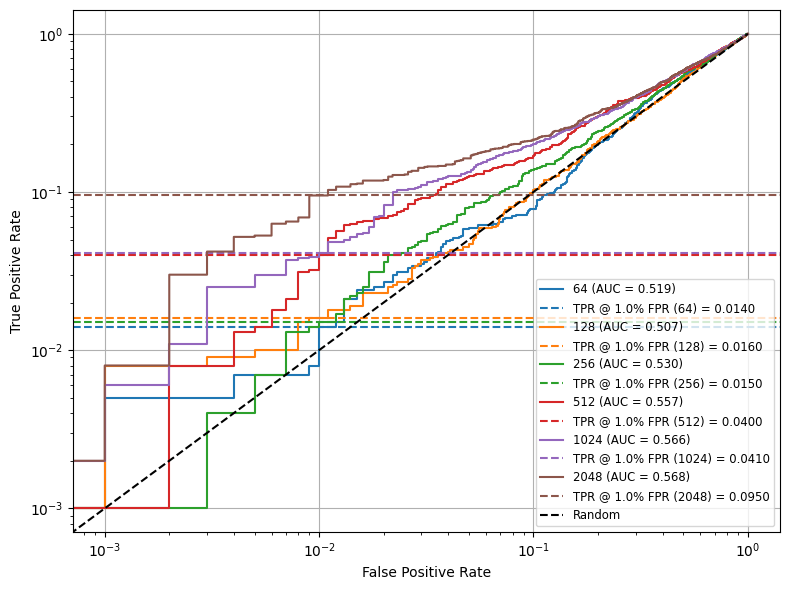

k: 20


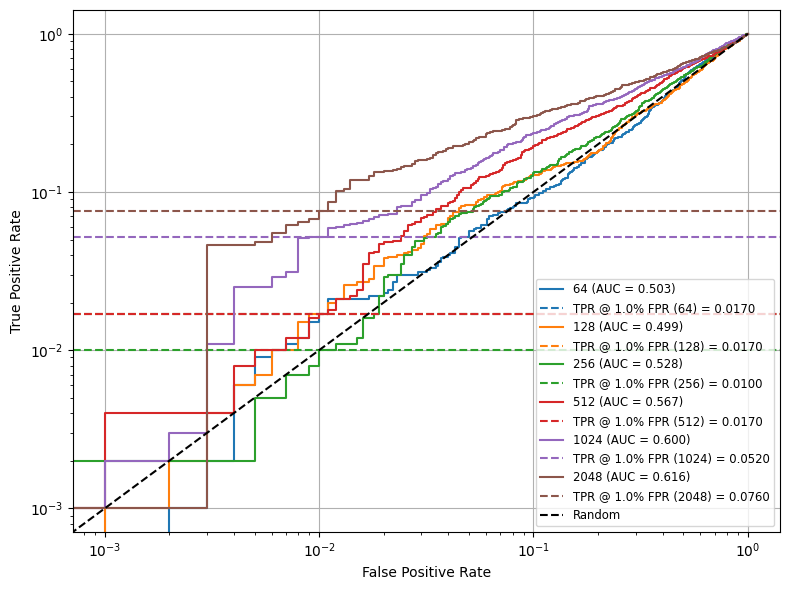

k: 30


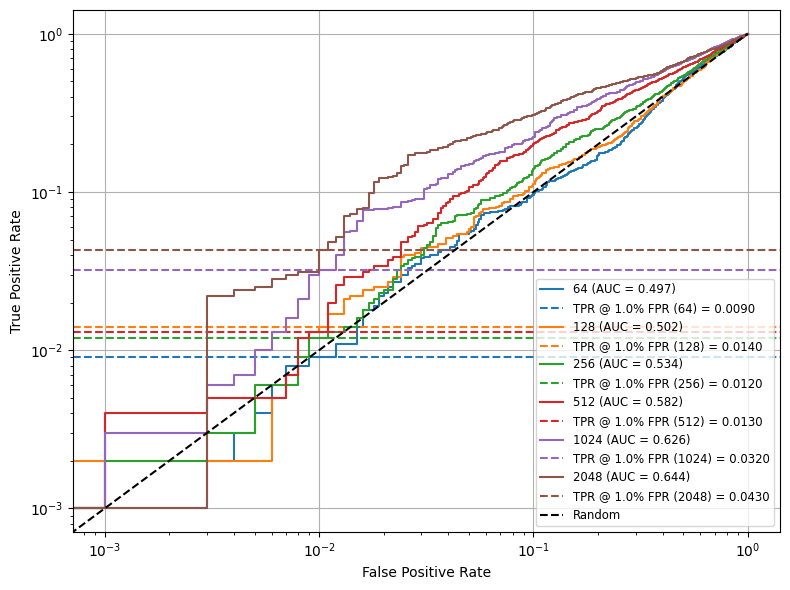

k: 40


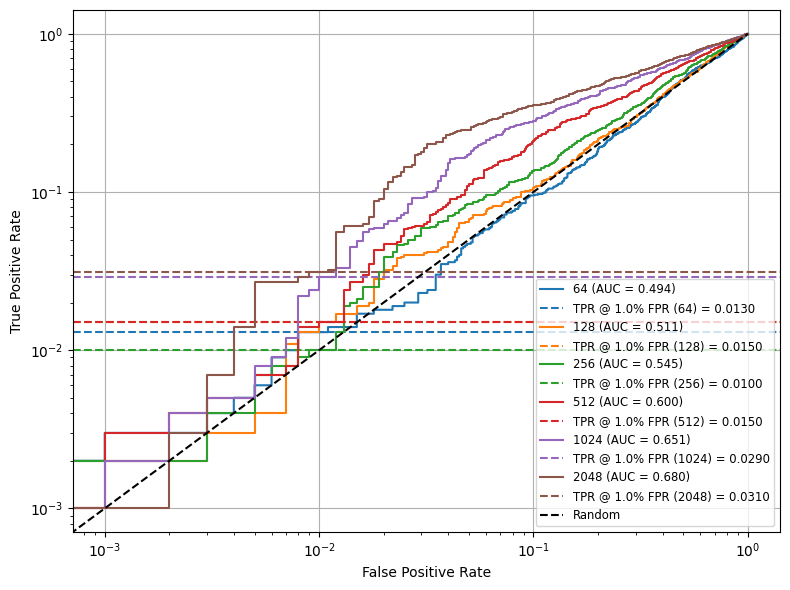

k: 50


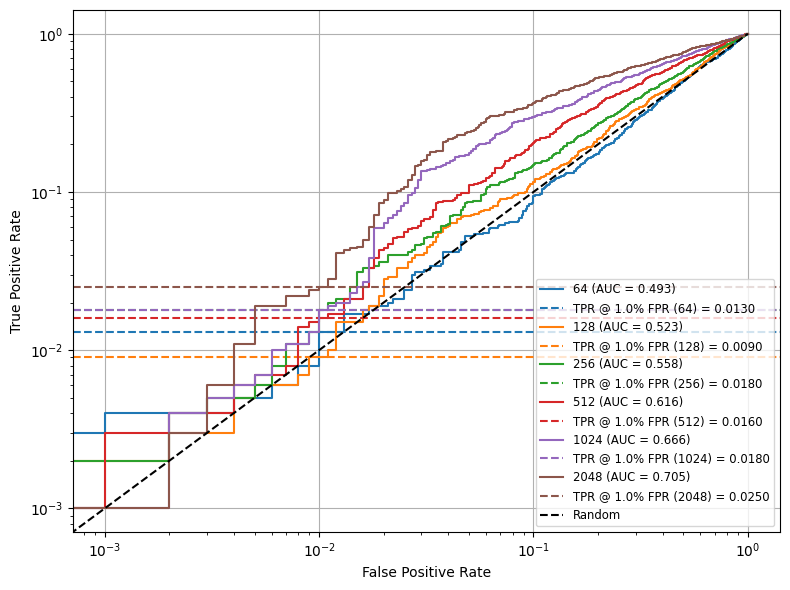

In [14]:
results_stability_ratio_k = {}

for k in [10,20,30,40,50]:
    print(f'k: {k}')
    results_stability_ratio_k[k] = {}
    results_stability_ratio_k[k]["AUC"], results_stability_ratio_k[k]["TPR"] = plot_metric_roc(dataset_wiki_pythia69b_normalised, k, compute_stability_ratio_metric)

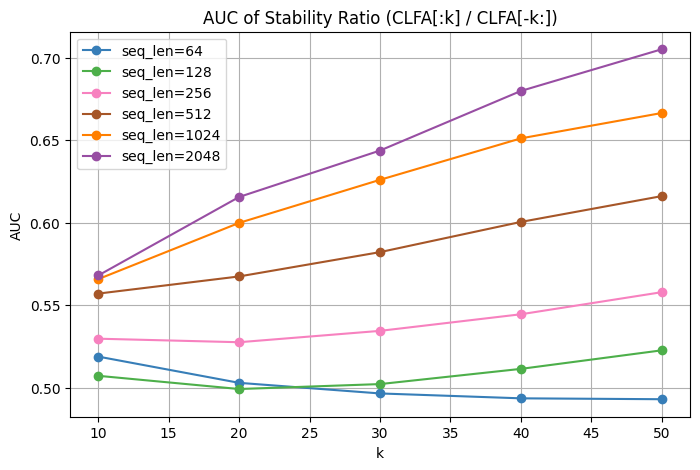

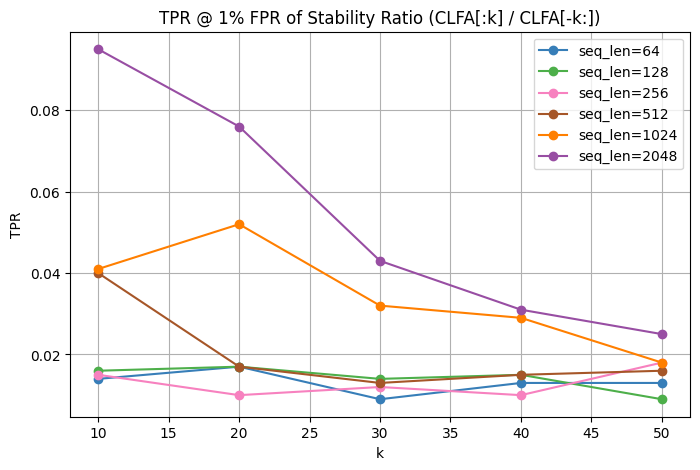

In [15]:
plot_auc_tpr_method(results_stability_ratio_k, title='Stability Ratio (CLFA[:k] / CLFA[-k:])')